## Setup

### Modules

We use `gensim`, since `gensim` has a much more readable implementation of Word2Vec (and Doc2Vec).

In [1]:
# gensim modules
from gensim import utils
from gensim.models.doc2vec import LabeledSentence
from gensim.models import Doc2Vec

# numpy
import numpy as np

# classifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC

# random
import random

# add path
import sys
my_path = r'home/ilaria/Scrivania/Machine_Learning/Project_2/Project2'
sys.path.insert(0,my_path + r'/code/COMMON')

#change path for data
import os
os.chdir(r'/home/ilaria/Scrivania/Machine_Learning/Project_2/Project2/data/twitter_datasets_epfl/short')

### Input Format

The samples contains tweet, each one taking up one entire line. Yes, **each document should be on one line, separated by new lines**. This is extremely important, because our parser depends on this to identify sentences.

### Feeding Data to Doc2Vec

Doc2Vec (the portion of `gensim` that implements the Doc2Vec algorithm) does a great job at word embedding, but a terrible job at reading in files. It only takes in `LabeledLineSentence` classes which basically yields `LabeledSentence`, a class from `gensim.models.doc2vec` representing a single sentence. Why the "Labeled" word? Well, here's how Doc2Vec differs from Word2Vec.

Word2Vec simply converts a word into a vector.

Doc2Vec not only does that, but also aggregates all the words in a sentence into a vector. To do that, it simply treats a sentence label as a special word, and does some voodoo on that special word. Hence, that special word is a label for a sentence. 

So we have to format sentences into

```python
[['word1', 'word2', 'word3', 'lastword'], ['label1']]
```

`LabeledSentence` is simply a tidier way to do that. It contains a list of words, and a label for the sentence. We don't really need to care about how `LabeledSentence` works exactly, we just have to know that it stores those two things -- a list of words and a label.

However, we need a way to convert our new line separated corpus into a collection of `LabeledSentence`s. The default constructor for the default `LabeledLineSentence` class in Doc2Vec can do that for a single text file, but can't do that for multiple files. In classification tasks however, we usually deal with multiple documents (test, training, positive, negative etc). Ain't that annoying?

So we write our own `LabeledLineSentence` class. The constructor takes in a dictionary that defines the files to read and the label prefixes sentences from that document should take on. Then, Doc2Vec can either read the collection directly via the iterator, or we can access the array directly. We also need a function to return a permutated version of the array of `LabeledSentence`s. We'll see why later on.

In [2]:
class LabeledLineSentence(object):
    def __init__(self, sources):
        self.sources = sources
        
        flipped = {}
        
        # make sure that keys are unique
        for key, value in sources.items():
            if value not in flipped:
                flipped[value] = [key]
            else:
                raise Exception('Non-unique prefix encountered')
    
    def __iter__(self):
        for source, prefix in self.sources.items():
            with open(source, 'r', encoding="ISO-8859-1") as fin:
                for item_no, line in enumerate(fin):
                    yield LabeledSentence(utils.to_unicode(line).split(), [prefix + '_%s' % item_no])
    
    def to_array(self):
        self.sentences = []
        for source, prefix in self.sources.items():
            print(source)
            with open(source, 'r', encoding="ISO-8859-1") as fin:
                for item_no, line in enumerate(fin):
                    self.sentences.append(LabeledSentence(utils.to_unicode(line).split(), [prefix + '_%s' % item_no]))
        return self.sentences
    
    def sentences_perm(self):
        shuffled = list(self.sentences)
        random.shuffle(shuffled)
        return shuffled

Now we can feed the data files to `LabeledLineSentence`. As we mentioned earlier, `LabeledLineSentence` simply takes a dictionary with keys as the file names and values the special prefixes for sentences from that document. The prefixes need to be unique, so that there is no ambiguitiy for sentences from different documents.

The prefixes will have a counter appended to them to label individual sentences in the documetns.

In [3]:
sources = {'train_neg_processed.txt':'TRAIN_NEG', 'train_pos_processed.txt':'TRAIN_POS', 'test_data_no_id_processed.txt':'TEST'}

sentences = LabeledLineSentence(sources)

## Model

### Building the Vocabulary Table

Doc2Vec requires us to build the vocabulary table (simply digesting all the words and filtering out the unique words, and doing some basic counts on them). So we feed it the array of sentences. `model.build_vocab` takes an array of `LabeledLineSentence`, hence our `to_array` function in the `LabeledLineSentences` class. 

If you're curious about the parameters, do read the Word2Vec documentation. Otherwise, here's a quick rundown:

- `min_count`: ignore all words with total frequency lower than this. You have to set this to 1, since the sentence labels only appear once. Setting it any higher than 1 will miss out on the sentences.
- `window`: the maximum distance between the current and predicted word within a sentence. Word2Vec uses a skip-gram model, and this is simply the window size of the skip-gram model.
- `size`: dimensionality of the feature vectors in output. 100 is a good number. If you're extreme, you can go up to around 400.
- `sample`: threshold for configuring which higher-frequency words are randomly downsampled
- `workers`: use this many worker threads to train the model 

In [4]:
model = Doc2Vec(min_count=1, window=10, size=100, sample=1e-4, negative=5, workers=7)

model.build_vocab(sentences.to_array())

train_neg_processed.txt


/home/ilaria/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:26: DeprecationWarning: Call to deprecated `LabeledSentence` (Class will be removed in 4.0.0, use TaggedDocument instead).


train_pos_processed.txt
test_data_no_id_processed.txt


### Training Doc2Vec

Now we train the model. The model is better trained if **in each training epoch, the sequence of sentences fed to the model is randomized**. This is important: missing out on this steps gives you really shitty results. This is the reason for the `sentences_perm` method in our `LabeledLineSentences` class.

We train it for 10 epochs. If I had more time, I'd have done 20.

This process takes around 10 mins, so go grab some coffee.

In [7]:
model.train(sentences.sentences_perm(), total_examples=model.corpus_count, epochs=10)

16035354

### Inspecting the Model

Let's see what our model gives. It seems that it has kind of understood the word `good`, since the most similar words to good are `glamorous`, `spectacular`, `astounding` etc. This is really awesome (and important), since we are doing sentiment analysis.

In [ ]:
model.most_similar('good')

We can also prop the hood open and see what the model actually contains. This is each of the vectors of the words and sentences in the model. We can access all of them using `model.syn0` (for the geekier ones among you, `syn0` is simply the output layer of the shallow neural network). However, we don't want to use the entire `syn0` since that contains the vectors for the words as well, but we are only interested in the ones for sentences.

Here's a sample vector for the first sentence in the training set for negative reviews:

In [ ]:
model.docvecs['TRAIN_POS_1']

## Classifying Sentiments

### Training Vectors


In [8]:
train_arrays = np.zeros((180000, 100))
train_labels = np.zeros(180000)

for i in range(90000):
    prefix_train_pos = 'TRAIN_POS_' + str(i)
    prefix_train_neg = 'TRAIN_NEG_' + str(i)
    train_arrays[i] = model.docvecs[prefix_train_pos]
    train_arrays[90000 + i] = model.docvecs[prefix_train_neg]
    train_labels[i] = 1
    train_labels[90000 + i] = -1

The training array looks like this: rows and rows of vectors representing each sentence.

In [9]:
print(train_arrays)

[[ -8.65951553e-03  -1.81227818e-01   1.75191388e-02 ...,  -1.23258188e-01
   -1.27799893e-02  -1.56774715e-01]
 [  8.29608552e-03   1.32956222e-01   3.84071320e-02 ...,  -1.06061772e-02
    7.48382583e-02   1.75294638e-01]
 [  1.11585677e-01  -7.31966496e-02   4.10510078e-02 ...,   9.28450227e-02
   -1.20057724e-01   7.61712715e-02]
 ..., 
 [  9.36760828e-02  -3.73742729e-02   5.13873249e-02 ...,  -7.17999041e-03
    1.05007784e-03   1.65333768e-04]
 [  1.64792791e-01  -9.49910432e-02   1.13734312e-01 ...,  -2.34314743e-02
   -8.21909010e-02  -1.72997434e-02]
 [ -7.73340240e-02   3.32785323e-02  -7.81462938e-02 ...,   1.13021567e-01
   -8.29291493e-02   2.00522259e-01]]


The labels are simply category labels for the sentence vectors -- 1 representing positive and 0 for negative.

In [10]:
print(train_labels)

[ 1.  1.  1. ..., -1. -1. -1.]


### Testing Vectors

We do the same for testing data -- data that we are going to feed to the classifier after we've trained it using the training data. This allows us to evaluate our results. The process is pretty much the same as extracting the results for the training data.

In [11]:
test_arrays = np.zeros((10000, 100))
test_labels = np.zeros(10000)

for i in range(10000):
    prefix_test = 'TEST_' + str(i)
    test_arrays[i] = model.docvecs[prefix_test]

## Hyperparameters optimization SVM : C and gamma

In [19]:
# shuffle of training matrix
ind = np.arange(train_arrays.shape[0])
ind_shuf = np.random.permutation(ind)

X_pos_neg = train_arrays[ind_shuf, :]
y_pos_neg = train_labels[ind_shuf]


# number of training samples
N_samples_train = 3500

# cut samples
X_cut = X_pos_neg[:N_samples_train,:]


# cut targets
y_cut = y_pos_neg[:N_samples_train]


## Grid search and cross validation

In [20]:
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report
from sklearn.svm import SVC
import datetime

# data
X = X_cut
y = y_cut

# Split the dataset in two equal parts
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=0)

# range for hyperparameters
C_range = np.logspace(-1, 3, 10)

gamma_range = np.logspace(-6, 2, 10)

# Set the parameters by cross-validation
tuned_parameters = [{'gamma': gamma_range, 'C': C_range}]
                    
# define grid search CV


start_time = datetime.datetime.now()
clf = GridSearchCV(SVC(kernel='rbf'), tuned_parameters, cv=5, scoring= 'accuracy')

# fit for every parameters combinations in grid search CV
clf.fit(X_train, y_train)

end_time = datetime.datetime.now()

exection_time = (end_time - start_time).total_seconds()
print("Grid Search: execution time={t:.3f} seconds".format(t=exection_time))

Grid Search: execution time=1358.185 seconds


# Display Results

In [21]:
print("Best parameters set found on development set:")
print()
print(clf.best_params_)
print()
print("Grid scores on development set:")
print()

means = clf.cv_results_['mean_test_score']
stds = clf.cv_results_['std_test_score']
for mean, std, params in zip(means, stds, clf.cv_results_['params']):
    print("%0.3f (+/-%0.03f) for %r"
          % (mean, std * 2, params))
    
print()
print("Detailed classification report:")
print()
print("The model is trained on the full development set.")
print("The scores are computed on the full evaluation set.")
print()
y_true, y_pred = y_test, clf.predict(X_test)
print(classification_report(y_true, y_pred))
print()

Best parameters set found on development set:

{'C': 2.1544346900318834, 'gamma': 1.6681005372000557}

Grid scores on development set:

0.500 (+/-0.001) for {'C': 0.10000000000000001, 'gamma': 9.9999999999999995e-07}
0.500 (+/-0.001) for {'C': 0.10000000000000001, 'gamma': 7.7426368268112769e-06}
0.500 (+/-0.001) for {'C': 0.10000000000000001, 'gamma': 5.9948425031894089e-05}
0.500 (+/-0.001) for {'C': 0.10000000000000001, 'gamma': 0.00046415888336127773}
0.500 (+/-0.001) for {'C': 0.10000000000000001, 'gamma': 0.0035938136638046258}
0.550 (+/-0.012) for {'C': 0.10000000000000001, 'gamma': 0.02782559402207126}
0.667 (+/-0.034) for {'C': 0.10000000000000001, 'gamma': 0.21544346900318823}
0.636 (+/-0.023) for {'C': 0.10000000000000001, 'gamma': 1.6681005372000557}
0.524 (+/-0.029) for {'C': 0.10000000000000001, 'gamma': 12.915496650148826}
0.500 (+/-0.001) for {'C': 0.10000000000000001, 'gamma': 100.0}
0.500 (+/-0.001) for {'C': 0.27825594022071243, 'gamma': 9.9999999999999995e-07}
0.500

In [22]:
scores = clf.cv_results_['mean_test_score']

In [23]:
scores

array([ 0.50026667,  0.50026667,  0.50026667,  0.50026667,  0.50026667,
        0.55013333,  0.66666667,  0.636     ,  0.524     ,  0.50026667,
        0.50026667,  0.50026667,  0.50026667,  0.50026667,  0.50026667,
        0.64666667,  0.69066667,  0.6832    ,  0.5272    ,  0.50026667,
        0.50026667,  0.50026667,  0.50026667,  0.50026667,  0.59093333,
        0.6848    ,  0.7056    ,  0.70826667,  0.55866667,  0.50026667,
        0.50026667,  0.50026667,  0.50026667,  0.50026667,  0.6552    ,
        0.70053333,  0.70906667,  0.71413333,  0.59546667,  0.50373333,
        0.50026667,  0.50026667,  0.50026667,  0.59573333,  0.692     ,
        0.70453333,  0.70826667,  0.6952    ,  0.59466667,  0.50373333,
        0.50026667,  0.50026667,  0.50026667,  0.6568    ,  0.69733333,
        0.70346667,  0.7008    ,  0.6872    ,  0.59466667,  0.50373333,
        0.50026667,  0.50026667,  0.59626667,  0.69146667,  0.70266667,
        0.70186667,  0.69813333,  0.68026667,  0.59466667,  0.50

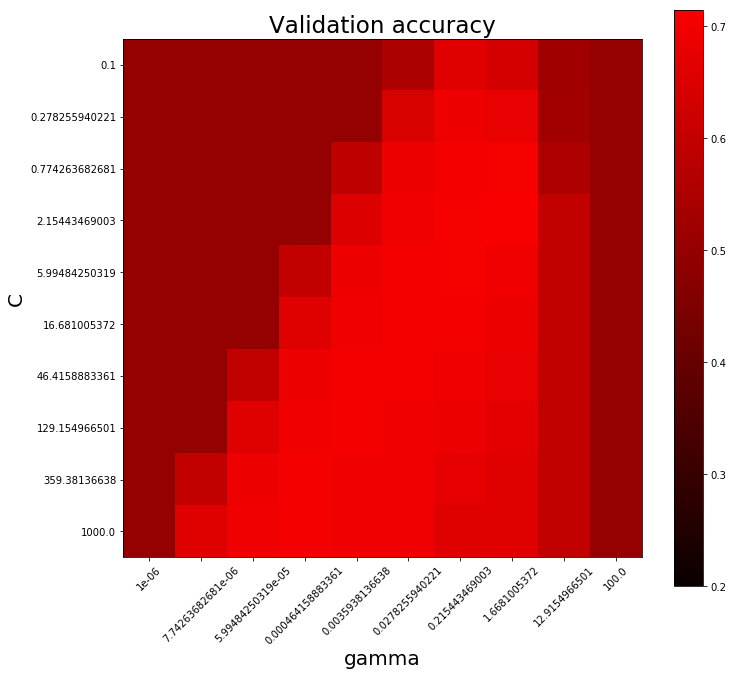

In [28]:
import matplotlib.pyplot as plt
from matplotlib.colors import Normalize

# Utility function to move the midpoint of a colormap to be around
# the values of interest.

class MidpointNormalize(Normalize):

    def __init__(self, vmin=None, vmax=None, midpoint=None, clip=False):
        self.midpoint = midpoint
        Normalize.__init__(self, vmin, vmax, clip)

    def __call__(self, value, clip=None):
        x, y = [self.vmin, self.midpoint, self.vmax], [0, 0.5, 1]
        return np.ma.masked_array(np.interp(value, x, y))

scores = clf.cv_results_['mean_test_score'].reshape(len(C_range), len(gamma_range))

plt.figure(figsize=(12,10))
plt.subplots_adjust(left=.2, right=0.95, bottom=0.15, top=0.95)
plt.imshow(scores, interpolation='nearest', cmap=plt.cm.hot, norm=MidpointNormalize(vmin=0.2, midpoint=0.92))
plt.xlabel('gamma',fontsize=20)
plt.ylabel('C', fontsize=20)
plt.colorbar()
plt.xticks(np.arange(len(gamma_range)), gamma_range, rotation=45)
plt.yticks(np.arange(len(C_range)), C_range)
plt.title('Validation accuracy', fontsize=23)
plt.savefig("Boh")
plt.show()